# Anisotrope Self-Organizing Map on Logistic map dataset

This example demonstrates the use of the anisotrope self-organizing map (ASOM) on a dataset generated by the logistic map.

1. **Generate the dataset**:
2. **Train the ASOM**
3. **Visualize the results**

In [7]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

 # add the Project path to PATH env variable
from anisom.datagen.logmap import gen_logmapdata
from helpers import positions, connections, plot_connectivity
from sklearn.preprocessing import scale


## 1. Generate the dataset

Generating dataset: 100%|██████████| 1/1 [00:00<00:00, 10.33it/s]

Dataset parameters:


({'r': array([3.9097627 , 3.94303787, 3.92055268]),
  'A': array([[1. , 0. , 0. ],
         [0.3, 1. , 0. ],
         [0.4, 0. , 1. ]]),
  'x0': array([0.54488318, 0.4236548 , 0.64589411])},)

'We generated 3 time series where the first one drives the second and the third one as a common driver.'

Dataset shape:


(2000, 3)

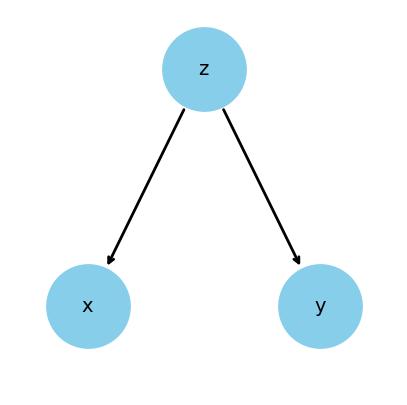

In [2]:
logmapgen_params = dict(N=1,  # number of realizations
                        n=2_000,  # Length of time series
                        rint=(3.8, 4.),  # interval to chose from the value of r parameter
                        A0=np.array([[0, 0, 0],
                                     [1, 0, 0],
                                     [1, 0, 0]]),  # basic connection structure
                        A=np.array([[1., 0., 0.],
                                    [0.3, 1., 0.],
                                    [0.4, 0., 1.]]),
                        # A = None,
                        )

dataset, params = gen_logmapdata(logmapgen_params)

n_train = 100  # number of training samples
n_valid = 500  # number of validation samples
n_test = 500  # number of test samples
x, y, z = dataset[0][:n_train, 1], dataset[0][:n_train, 2], dataset[0][:n_train, 0]
x_valid, y_valid, z_valid = dataset[0][n_train:n_train + n_valid, 1], dataset[0][n_train:n_train + n_valid, 2], dataset[0][n_train:n_train + n_valid, 0]
z_test, y_test, x_test = dataset[0][n_train + n_valid:, 0], dataset[0][n_train + n_valid:, 2], dataset[0][n_train + n_valid:, 1]

print("Dataset parameters:")
display(params)
display("We generated 3 time series where the first one drives the second and the third one as a common driver.")

print("Dataset shape:")
display(dataset[0].shape)

_ = plot_connectivity(positions, connections)



In [3]:
print("The shape of time series:", "len(x):", x.shape, "len(y):",y.shape, "len(z):",z.shape)

The shape of time series: len(x): (100,) len(y): (100,) len(z): (100,)


## 2. Train the ASOM

In [4]:
from anisom.preprocessing.tde import time_delay_embedding
from anisom.network.anisom import AniSOM
import torch

def run_anisom(x : np.ndarray, y : np.ndarray, 
               embedding_params : dict,
               anisom_params : dict,
               x_valid: np.ndarray = None,
               fit_params: dict = None) -> tuple[AniSOM, np.ndarray]:
        """Small utility function to run AniSOM on two time series.

        :param np.ndarray x: First time series
        :param np.bdarray y: Second time series
        :param np.ndarray x_valid: Optional validation time series
        :param dict embedding_params: Parameters for time delay embedding
        :param dict anisom_params: Parameters for AniSOM
        :param dict fit_params: Parameters for fitting the model
        :return: Fitted AniSOM model and the predicted latent space representations
        :rtype: tuple(AniSOM, np.ndarray)

        """
        # 1. embed the time series
        X = time_delay_embedding(x, **embedding_params)
        Y = time_delay_embedding(y, **embedding_params)

        if x_valid is not None:
                X_valid = time_delay_embedding(x_valid, **embedding_params)
        else:
                X_valid = None

        # Convert to torch tensors
        X = torch.tensor(X)
        Y = torch.tensor(Y)
        if X_valid is not None:
                X_valid = torch.tensor(X_valid)

        # 2. initialize and fit the model
        model = AniSOM(**anisom_params)
        model.fit(X, Y, **fit_params, x_valid=X_valid)

        # 3. predict the latent space representations
        z = model.predict(X)
        z = z.detach().numpy()

        return model, z

# Define parameters for time delay embedding
d = 3
tau = 1
embedding_params = dict(
        dimension=d,
        delay=tau
        )

# parameters for AniSOM
anisom_params = dict(
        space_dim=d,  # the input space dimension
        grid_dim=2,  # the number of dimensions of the grid
        sizes=[40, 20]  # grid size along each dimension
        )

fit_params = dict(
        epochs=200,
        disable_tqdm=False
        )

# Run AniSOM on the first time series
model, z_pred = run_anisom(x, y,
                           x_valid=x_valid,
                           embedding_params=embedding_params,
                           anisom_params=anisom_params,
                           fit_params=fit_params)

  0%|          | 0/19600 [00:00<?, ?it/s]

100%|██████████| 19600/19600 [02:25<00:00, 134.99it/s]


Score: 0.0365


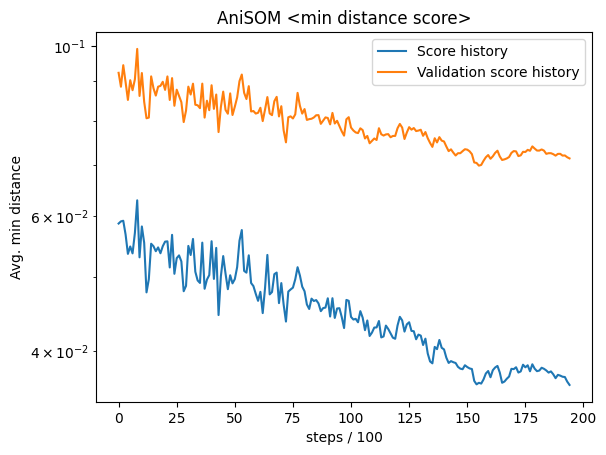

In [5]:
# Compute the score
X = time_delay_embedding(x, delay=1, dimension=3)
X = torch.tensor(X)

score = model.compute_score(X)
print(f"Score: {score:.4f}")

plt.figure()
plt.plot(model.score_history[5:], label='Score history')
plt.plot(model.validation_score_history[5:], label='Validation score history')
plt.xlabel('steps / 100')
plt.ylabel('Avg. min distance')
plt.title('AniSOM <min distance score>')
plt.yscale('log')

plt.legend()


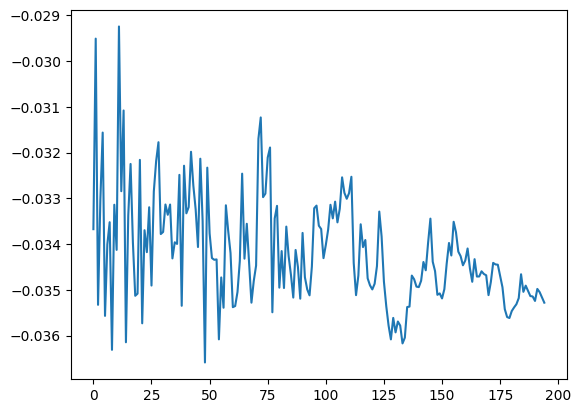

In [6]:
# plot the difference between history and validation hittory
plt.figure()
plt.plot((np.array(model.score_history[5:]) - np.array(model.validation_score_history[5:])), 
         label='train - validation')


0.36383790207805033


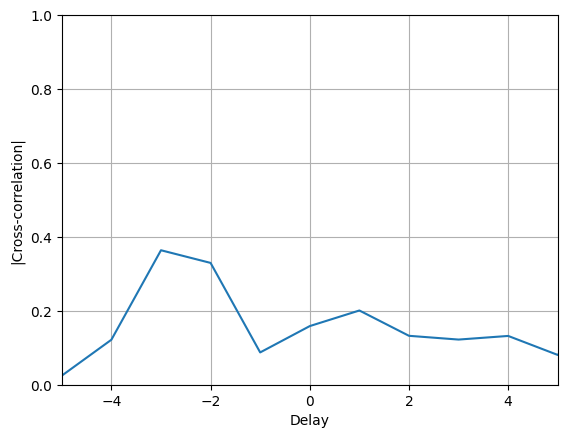

In [8]:

z_pred = scale(z_pred, axis=0)  # scale the predicted latent space
z = scale(z, axis=0)  # scale the original latent space

np.corrcoef(z_pred[:, 1], z[:-2])[0, 1]  # correlation between the second component of the latent space and the second time series

ccr = np.correlate(scale(z_pred[:, 1]), scale(z[:-2]), mode='full') / len(z_pred[:, 1])
# get the delay for the crosscorrelation
delay = np.arange(-len(z_pred) + 1, len(z_pred))
plt.figure()
plt.plot(delay, (ccr**2)**0.5, label='Cross-correlation')
plt.xlabel('Delay')
plt.ylabel('|Cross-correlation|')

plt.xlim(-5, 5)
plt.ylim([0., 1])
plt.grid()

print(np.max(np.abs(ccr)))

## 3. Visualize the results

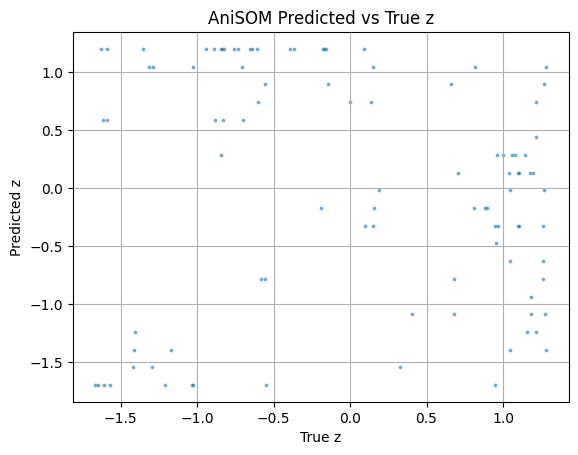

In [9]:
# z.shape, z_pred.shape
l = len(z_pred)
plt.figure()
plt.scatter(z[1:l+1], z_pred[:l, 1],s=3, alpha=0.5)
plt.ylabel('Predicted z')
plt.xlabel('True z')
plt.title('AniSOM Predicted vs True z')
plt.grid()